In [ ]:
#model.save('/content/drive/MyDrive/CNN/ModelData')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import all dependencies, Define functions to be used to build and train model

In [ ]:
#train
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import os
import numpy as np
import pandas as pd
import cv2
from glob import glob
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.applications import DenseNet201, VGG19, Xception, ResNet50
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

data_augmentation = Sequential(
   [
     RandomFlip("horizontal"),
     RandomZoom(0.1),
     RandomContrast(0.2)
   ]
)

def build_model(size, num_classes):
    inputs = Input((size, size, 3))
    x = tf.cast(inputs, tf.float32)
    x = tf.keras.applications.resnet50.preprocess_input(x)
    #x = tf.keras.applications.xception.preprocess_input(x)
    #x = tf.keras.applications.densenet.preprocess_input(x)
    #aug_inputs = data_augmentation(x)
    backbone = ResNet50(input_tensor=x, include_top=False, weights="imagenet")
    backbone.trainable = False
    x = backbone.output
    x = Dropout(0.25)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.25)(x)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.25)(x)
    x = Dense(1024, activity_regularizer=regularizers.l2())(x)
    x = Dropout(0.25)(x)
    x = Dense(num_classes, activation="softmax", activity_regularizer=regularizers.l2())(x)
    x = Flatten()(x)

    model = tf.keras.Model(inputs, x)
    return model
#Reads image, resizes images to size passed in, then converts to a numpy array
def read_image(path, size):
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (size, size))
    #image = image / 255.0
    image = image.astype(np.float32)
    return image

#decodes x data from utf-8, num_class = number of breeds classified, size = the dimensions of the image
#creates a label array with num_class indices, then converts labels to a numpy array as int32
def parse_data(x, y):
    x = x.decode()

    num_class = 120
    size = 224

    image = read_image(x, size)
    label = [0] * num_class
    label[y] = 1
    label = np.array(label)
    label = label.astype(np.int32)

    return image, label

#calls parse_data on x and y passed into the function, then sets the shape of the numpy array
#to 224x224x3 for x and 120 for y
def tf_parse(x, y):
    x, y = tf.numpy_function(parse_data, [x, y], [tf.float32, tf.int32])
    x.set_shape((224, 224, 3))
    y.set_shape((120))
    return x, y

#retreives the data from x and y and slices it into a image and label tuple,
#the dataset is then mapped with the converted information and broken up into *batch* number of batches
def tf_dataset(x, y, batch):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    return dataset

    
    

In [ ]:
#Paths are established to be used via glob later on
path = "/content/drive/MyDrive/CNN"
train_path = os.path.join(path, "Images/*/*")
labels_path = os.path.join(path, "labels_full.csv")

#using pandas to read in the csv of labels as a dataframe
labels_df = pd.read_csv(labels_path)
#breed is established as a dataframe of all 120 unique dog breeds we are going to classify
breed = labels_df["breed"].unique()
#print number of breeds to verify
print("Number of Breeds: ", len(breed))
#convert breed names to integers
breed2id = {name: i for i, name in enumerate(breed)}
#ids is a list of all image paths in the training set
ids = glob(train_path)
#labels array is created
labels = []
#each element in ids is parsed so that the file extensions and preceding pathnames are removed
#then each image is paired with its respective breed as an integer
for image_id in ids:
    image_id = image_id.split("/")[-1].split(".")[0]
    breed_name = list(labels_df[labels_df.id == image_id]["breed"])[0]
    breed_idx = breed2id[breed_name]
    labels.append(breed_idx)
#LEN is the length of data you would like to train on,
#if you are getting long epoch wait times reduce this number
LEN = 1000
print("data length: " + str(len(ids)))
ids = ids[:LEN]
labels = ids[:LEN]

## Spliting the dataset
train_x, valid_x = train_test_split(ids, test_size=0.1, random_state=0)
train_y, valid_y = train_test_split(labels, test_size=0.1, random_state=0)

#trim down data AFTER splitting lets us suffle the data in order to 
#get a better distribution of most of the breeds.
#The training dataset becomes the first *LEN* elements of each list
#train_x = train_x[:LEN]
#train_y = train_y[:LEN]
#the validation dataset becomes the first *LEN*/10 elements of each list
#valid_x = valid_x[:int(LEN/10)]
#valid_y = valid_y[:int(LEN/10)]
print("new training data length: " + str(len(train_x)))
print("new testing data length: " + str(len(valid_x)))

Number of Breeds:  120
data length: 20590
new training data length: 900
new testing data length: 100


Set Parameters, Build Model, and Train Model

In [ ]:
## Parameters
size = 224
num_classes = 120
lr = 1e-1
batch = 64
epochs = 20

## Build Model
model = build_model(size, num_classes)
model.compile(loss="categorical_crossentropy", optimizer=SGD(lr), metrics=["acc"])
##uncomment next line to see the structure of the model
#model.summary()

## convert lists to tf Datasets
train_dataset = tf_dataset(train_x, train_y, batch=batch)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch)

#sets the path in which to save the model (we mostly want this to use the weights for further training)
checkpoint_path = "/content/drive/MyDrive/CNN/Xception_11_26_21.h5"
##run once first, then uncomment next line and run again to load previous weights
#model.load_weights(checkpoint_path)

## Training
callbacks = [
      ModelCheckpoint(checkpoint_path, verbose=1, save_best_only=True),
      #this will reduce the learning rate in case of a dropoff in validation loss
      ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=3, min_lr=1e-6,verbose=1),
      #this will stop the model from training if the validation lass does not improve after 5 epochs
      EarlyStopping(monitor="val_loss",patience=5, verbose=1)
]
train_steps = (len(train_x)//batch) + 1
valid_steps = (len(valid_x)//batch) + 1
#saves the training metrics to a variable to be plotted later
history = model.fit(train_dataset,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    validation_data=valid_dataset,
    epochs=epochs,
    callbacks=callbacks)


Plot Results in better format

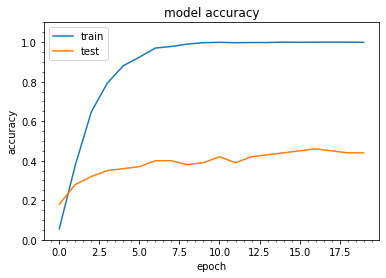

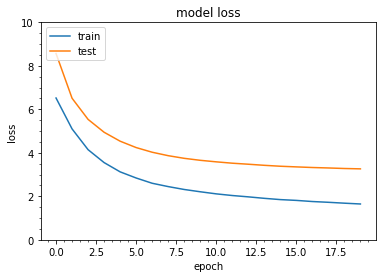

In [ ]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.minorticks_on()
plt.ylim((0,1.1))
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.minorticks_on()
plt.ylim(0,10)
plt.show()

Run a test to see results

In [ ]:
#test
import os
import random
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
import tensorflow as tf
from sklearn.model_selection import train_test_split

def read_image(path, size = 224):
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (size, size))
    image = image / 255.0
    image = image.astype(np.float32)
    return image

path = "/content/drive/MyDrive/CNN"
test_path = os.path.join(path, "TestImages/*")
labels_path = os.path.join(path, "labels_full.csv")
print(test_path)

labels_df = pd.read_csv(labels_path)
breed = labels_df["breed"].unique()
print("Number of Breed: ", len(breed))

breed2id = {name: i for i, name in enumerate(breed)}
id2breed = {i: name for i, name in enumerate(breed)}

ids = glob(test_path)
labels = []

## Model
model = tf.keras.models.load_model("/content/drive/MyDrive/CNN/DenseNet201.h5")

for i, path in enumerate(ids):
    print(path)
    breed_name = path.split("/")[-1].split(".")[0]
    print(breed_name)
    ori_breed = breed_name
    image = read_image(path, 224)
    image = np.expand_dims(image, axis=0)
    pred = model.predict(image)[0]
    label_idx = np.argmax(pred)
    breed_name = id2breed[label_idx]
    ori_image = cv2.imread(path, cv2.IMREAD_COLOR)
    ori_image = cv2.putText(ori_image, ("Best Guess: " + breed_name), (0, 10), cv2.FONT_HERSHEY_PLAIN, 0.5, (0, 0, 0), 1)
    ori_image = cv2.putText(ori_image, ("True Label: " + ori_breed), (0, 30), cv2.FONT_HERSHEY_PLAIN, 0.5, (0, 0, 0), 1)
    print("Best Guess: " + breed_name)
    print("True Label: " + ori_breed)
    cv2.imwrite(f"/content/drive/MyDrive/CNN/save/test_{i}.png", ori_image)
    

    plt.imshow(cv2.cvtColor(ori_image, cv2.COLOR_BGR2RGB))
    plt.show()

Python script to write a csv file containing the entire dataset

In [ ]:
import csv
import os
import glob

with open('/content/drive/MyDrive/CNN/labels_full.csv', 'w', newline='') as f:
  write = csv.writer(f)
  write.writerow(['id','breed'])

  images_list = glob.glob('/content/drive/MyDrive/CNN/Images/*/*')
  breeds_list = glob.glob('/content/drive/MyDrive/CNN/Images/*')
  for data in images_list:
    data = data.split('/')
    breed = data[6].split('-')[1]
    image_path = data[7].split('.')[0]
    write.writerow([image_path, breed])
    #print(breed + " " + image_path)




In [ ]:
#test to see if the read from the new csv will work properly

if __name__ == "__main__":
    path = "/content/drive/MyDrive/CNN"
    train_path = os.path.join(path, "Images/*/*")
    labels_path = os.path.join(path, "labels_full.csv")

    labels_df = pd.read_csv(labels_path)
    breed = labels_df["breed"].unique()
    print("Number of Breed: ", len(breed))

    breed2id = {name: i for i, name in enumerate(breed)}

    ids = glob(train_path)
    labels = []
    print(len(ids))


    for image_id in ids:
        image_id = image_id.split("/")[-1].split(".")[0]
        breed_name = list(labels_df[labels_df.id == image_id]["breed"])[0]
        breed_idx = breed2id[breed_name]
        labels.append(breed_idx)

    print("data length: " + str(len(ids)))
    #ids = ids[:10222]
    #labels = labels[:10222]
    print("new data length: " + str(len(ids)))
    ## Spliting the dataset
    train_x, valid_x = train_test_split(ids, test_size=0.1, random_state=0)
    train_y, valid_y = train_test_split(labels, test_size=0.1, random_state=0)



In [ ]:
import os
import random
import numpy as np
import pandas as pd
import cv2
from glob import glob
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split



path = "/content/drive/MyDrive/CNN"
train_path = os.path.join(path, "Images/**/*")
labels_path = os.path.join(path, "labels_full.csv")


labels_df = pd.read_csv(labels_path)
breed = labels_df["breed"].unique()
print("Number of Breed: ", len(breed))

breed2id = {name: i for i, name in enumerate(breed)}
id2breed = {i: name for i, name in enumerate(breed)}

ids = glob(train_path)
labels = []

for image_id in ids:
    image_id = image_id.replace("\\","/")
    image_id = image_id.split("/")[-1].split(".")[0].split("-")[0]
    breed_name = list(labels_df[labels_df.id == image_id]["breed"])[0]
    breed_idx = breed2id[breed_name]
    labels.append(breed_idx)

#ids = ids[:1000]
#labels = labels[:1000]

## Spliting the dataset
train_x, valid_x = train_test_split(ids, test_size=0.1, random_state=0)
train_y, valid_y = train_test_split(labels, test_size=0.1, random_state=0)

## Model
checkpoint_path = "/content/drive/MyDrive/CNN/BackupCallbackFile.h5"
model = tf.keras.models.load_model(checkpoint_path)
denominator = 100
numerator = 0
for i, path in tqdm(enumerate(valid_x[:denominator])):
    image = read_image(path, 224)
    image = np.expand_dims(image, axis=0)
    pred = model.predict(image)[0]
    label_idx = np.argmax(pred)
    breed_name = id2breed[label_idx]

    ori_breed = id2breed[valid_y[i]]
    ori_image = cv2.imread(path, cv2.IMREAD_COLOR)

    ori_image = cv2.putText(ori_image, breed_name, (0, 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 255), 1)
    ori_image = cv2.putText(ori_image, ori_breed, (0, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 100), 1)

    #cv2.imwrite("C:/Users/seanm/Downloads/save/testing_"+str(i)+".png", ori_image)

    #plt.imshow(cv2.cvtColor(ori_image, cv2.COLOR_BGR2RGB))
    #plt.show()

    if(breed_name == ori_breed):
      numerator += 1
print("\nTesting accuracy: " + str(numerator/denominator))
